In [1]:
import torch

In [2]:
import gymnasium as gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [131]:
env = gym.make('CartPole-v1')
# num_features
D = env.observation_space.shape[0]

# num actions, num targets for policy prediction
K = env.action_space.n
print("D: ", D)
print("K: ", K)

D:  4
K:  2


In [369]:
# approximates pi(a | s)
class PolicyModelTorch(torch.nn.Module):
  def __init__(self, D, K, hidden_layer_sizes):
    super().__init__()
    self.nn_model = torch.nn.Sequential()
    prev_dim = D
    for layer_num, layer_size in enumerate(hidden_layer_sizes):
        self.nn_model.add_module(f"fc_{layer_num}", torch.nn.Linear(prev_dim, layer_size))
        self.nn_model.add_module(f"act_{layer_num}", torch.nn.ReLU())
        prev_dim = layer_size
    self.nn_model.add_module("final_hidden_layer", torch.nn.Linear(prev_dim, K))
    self.nn_model.add_module("softmax", torch.nn.Softmax())

  def predict(self, X):
    return self.nn_model(X)

  def sample_action(self, X):
# return self.predict(X)
    with torch.no_grad():
        p = self.predict(X).numpy()
#         print("in sample action predict: ", p)
#         p /= p.sum()
       # return np.random.multinomial(len(p), p)
        p[-1] = 1 - np.sum(p[0:-1])
        return np.random.choice(len(p), p=p)


def policy_cost_function(preds, actions, advantages, K):
    # actions is a bunch of indices of (num_examples,) K is num_actions.
    # preds should be (num_examples, num_actions)
    # advantages are (num_examples,)
    # (num_examples, num_actions)
#     print("preds: ", preds)
    pred_action_scores = preds * torch.nn.functional.one_hot(actions, K)
#     print("pred_action_scores: ", pred_action_scores)
    # (num_examples,)
    selected_probs = torch.log(torch.sum(pred_action_scores, 1))
#     print("selected_probs: ", selected_probs)
    cost = -torch.sum(advantages * selected_probs)
    #cost = torch.sum(advantages * selected_probs)
    return cost

In [370]:
# approximates V(s)
class ValueModelTorch(torch.nn.Module):
  def __init__(self, D, hidden_layer_sizes):
    super().__init__()
    self.nn_model = torch.nn.Sequential()
    M1 = D
    for layer_num, M2 in enumerate(hidden_layer_sizes):
        self.nn_model.add_module(f"fc_{layer_num}", torch.nn.Linear(M1, M2))
#         self.nn_model.add_module(f"act_{layer_num}", torch.nn.Tanh())
        self.nn_model.add_module(f"act_{layer_num}", torch.nn.ReLU())
        M1 = M2
    self.nn_model.add_module("final_hidden_layer", torch.nn.Linear(M1, 1))
      
    #self.cost = torch.nn.MSELoss()

#     # calculate output and cost
#     Z = self.X
#     for layer in self.layers:
#       Z = layer.forward(Z)
#     Y_hat = tf.reshape(Z, [-1]) # the output
#     self.predict_op = Y_hat

#     cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
#     self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

#   def partial_fit(self, X, Y):
#     self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

  def predict(self, X):
    return self.nn_model(X)


  def cost_function(self, preds, actuals):
    return torch.sum((actuals - preds)**2)
    #return self.cost(preds, actuals)
    
   

In [371]:
env = gym.make('CartPole-v1')
D = env.observation_space.shape[0]
K = env.action_space.n
# pmodel = torch.nn.Sequential(torch.nn.Linear(D, K))
pmodel = torch.nn.Sequential()
pmodel.add_module("final_hidden_layer", torch.nn.Linear(D, K))
pmodel.add_module("softmax", torch.nn.Softmax())
print(pmodel)

observation = env.reset()[0]
print(observation)
# with torch.no_grad():
obs_tensor = torch.from_numpy(observation)
print(pmodel(obs_tensor))
# observation, reward, done, trunc, info = env.step(action)

Sequential(
  (final_hidden_layer): Linear(in_features=4, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)
[-0.0218732   0.01179097 -0.01360124 -0.03104817]
tensor([0.3540, 0.6460], grad_fn=<SoftmaxBackward0>)


In [372]:
env = gym.make('CartPole-v1')
D = env.observation_space.shape[0]
K = env.action_space.n
gamma = 0.99


pmodel = PolicyModelTorch(D, K, [])
print(pmodel)
#vmodel = ValueModel(D, [10])
vmodel = ValueModelTorch(D, [10])

p_optimizer = torch.optim.SGD(pmodel.parameters(), lr=0.015)
v_optimizer = torch.optim.SGD(vmodel.parameters(), lr=0.015)

observation = env.reset()[0]
print(observation)

obs_tensor = torch.from_numpy(observation)
action = pmodel.sample_action(obs_tensor)
observation1, reward, done, trunc, info = env.step(action)


print("obs1: ", observation1)
# update the models
V_next = vmodel.predict(torch.from_numpy(observation1))
print("V_next: ", V_next)
print("reward: ", reward)
G = reward + gamma*V_next
advantage = G - vmodel.predict(obs_tensor)
print("G: ", G)
print("advantage: ", advantage)


vcost = vmodel.cost_function(torch.from_numpy(observation), G)
print("vcost: ", vcost)
vcost.backward()
v_optimizer.step()

cost = policy_cost_function(pmodel.predict(torch.from_numpy(observation)), 
                            torch.tensor([action]), torch.tensor(advantage.detach().numpy()), K)
cost.backward()
p_optimizer.step()

p_optimizer.zero_grad()
v_optimizer.zero_grad()


# if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
#     action = pmodel.sample_action(observation)
#     prev_observation = observation
#     observation, reward, done, trunc, info = env.step(action)


#     # update the models
#     V_next = vmodel.predict(observation)[0]
#     G = reward + gamma*V_next
#     advantage = G - vmodel.predict(prev_observation)
#     pmodel.partial_fit(prev_observation, action, advantage)
#     vmodel.partial_fit(prev_observation, G)

#     if reward == 1: # if we changed the reward to -200
#       totalreward += reward
#     iters += 1



PolicyModelTorch(
  (nn_model): Sequential(
    (final_hidden_layer): Linear(in_features=4, out_features=2, bias=True)
    (softmax): Softmax(dim=None)
  )
)
[-0.02737204 -0.04781248  0.01557279  0.02509952]
obs1:  [-0.02832829 -0.24315426  0.01607478  0.32265487]
V_next:  tensor([-0.2451], grad_fn=<AddBackward0>)
reward:  1.0
G:  tensor([0.7574], grad_fn=<AddBackward0>)
advantage:  tensor([0.9907], grad_fn=<SubBackward0>)
vcost:  tensor(2.3505, grad_fn=<SumBackward0>)


In [429]:
def play_one_mc(env, pmodel, vmodel, gamma, p_opt, v_opt):
  observation = env.reset()[0]
  done = False
  totalreward = 0
  iters = 0
  num_examples = 2000
  # (num_examples, 4)
  states = []
#   states = np.zeros((num_examples, D), dtype=np.float32)
  # (num_examples,)
  actions = []
#   actions = np.zeros((num_examples,), dtype=int)
  # can be a list
  rewards = []

  reward = 0
#   with torch.no_grad():
#   while not done and iters < 2000:
  while (not done and not trunc) and iters < num_examples:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(torch.from_numpy(observation))
#     states[num_examples - iters - 1, :] = observation
    states.append(observation)
    actions.append(action)
    rewards.append(reward)

    prev_observation = observation
    observation, reward, done, trunc, info = env.step(action)

    if done or trunc:
      reward = -200

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  # save the final (s,a,r) tuple
  action = pmodel.sample_action(torch.from_numpy(observation))
  states.append(observation)
  actions.append(action)
  rewards.append(reward)

  returns = []
  advantages = []
  G = 0
  for s, r in zip(reversed(states), reversed(rewards)):
    returns.append(G)
    advantages.append(G - vmodel.predict(torch.tensor(s)))
    G = r + gamma*G
  returns.reverse()
  advantages.reverse()
    
#   print("states: ", len(states), states)
#   print("advantges: ", len(advantages), advantages)
#   print("returns: ", len(returns), returns)
#   print("actions: ", len(actions), actions)

  stacked_states = np.stack(states)
  stacked_advantages = np.stack([a.detach().numpy() for a in advantages])
  # update the models
  vcost = vmodel.cost_function(torch.squeeze(vmodel.predict(torch.from_numpy(stacked_states))), 
                              torch.FloatTensor(returns))
  vcost.backward()
  v_opt.step()
  cost = policy_cost_function(pmodel.predict(torch.from_numpy(stacked_states)), 
                              torch.tensor(actions),
                              torch.from_numpy(stacked_advantages), K)
  cost.backward()
  p_opt.step()
  
#   pmodel.partial_fit(states, actions, advantages)
#   vmodel.partial_fit(states, returns)

  p_opt.zero_grad()
  v_opt.zero_grad()
  return totalreward

In [453]:
def play_one_td(env, pmodel, vmodel, gamma, p_opt, v_opt):
  observation = env.reset()[0]
  trunc = done = False
  totalreward = 0
  iters = 0

  while (not done and not trunc) and iters < 10:
#   while not done and iters < 20:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(torch.from_numpy(observation))
    prev_observation = observation
    observation, reward, done, trunc, info = env.step(action)

#     if done or trunc:
#       print("##########################################")
#       print("Done at iters: ", iters, done, trunc,reward, cost, advantage)
#       print("##########################################")
#       reward = -200

    # update the models
#     with torch.no_grad():
    V_next = vmodel.predict(torch.from_numpy(observation))
    G = reward + gamma*V_next
    advantage = G - vmodel.predict(torch.from_numpy(prev_observation))
#     pmodel.partial_fit(prev_observation, action, advantage)
#     vmodel.partial_fit(prev_observation, G)
    #adv_copy = torch.tensor(advantage.detach().numpy())
    
    p_opt.zero_grad()
    cost = policy_cost_function(pmodel.predict(torch.from_numpy(prev_observation)), 
                                torch.tensor([action]),
                                advantage, K)
#     print("##########################################")
#     print("pmodel before backward: ", pmodel.nn_model[0].weight.grad)
    
    cost.backward()
#     print("pmodel after backward: ", pmodel.nn_model[0].weight.grad)
#     print("##########################################")
    p_opt.step()
    
    
    v_opt.zero_grad()
    G_copy = torch.tensor(G.detach().numpy())
    vcost = vmodel.cost_function(vmodel.predict(torch.from_numpy(prev_observation)), 
                              G_copy)
#     print("##########################################")
#     print("vmodel before backward: ", vmodel.nn_model[0].weight.grad)
    vcost.backward()
#     print("vmodel after backward: ", vmodel.nn_model[0].weight.grad)
#     print("##########################################")
    v_opt.step()
    
    
    
#     if done or trunc:
#         print("##########################################")
#         print("Done at iters: ", iters, done, trunc,reward, cost, advantage)
#         print("##########################################")

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward

In [461]:
env = gym.make('CartPole-v1')
D = env.observation_space.shape[0]
K = env.action_space.n
pmodel = PolicyModelTorch(D, K, [])
vmodel = ValueModelTorch(D, [10])
print(pmodel)
print(vmodel)
print("before playing pmodel: ", pmodel.nn_model[0].weight)
print("before playing vmodel: ", vmodel.nn_model[0].weight)


#print("num p params: ", [p for p in pmodel.parameters()])
# p_opt = torch.optim.Adam(pmodel.parameters(), lr=0.01, weight_decay=0.99)
# v_opt = torch.optim.Adam(vmodel.parameters(), lr=0.01, weight_decay=0.99)
p_opt = torch.optim.Adagrad(pmodel.parameters(), lr=0.005, lr_decay=0.99)
v_opt = torch.optim.Adagrad(vmodel.parameters(), lr=0.005, lr_decay=0.99)
gamma = 0.99

N = 1000
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    #totalreward = play_one_mc(env, pmodel, vmodel, gamma, p_opt, v_opt)
    total_reward = play_one_td(env, pmodel, vmodel, gamma, p_opt, v_opt)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

print("after playing pmodel: ", pmodel.nn_model[0].weight)
print("after playing vmodel: ", vmodel.nn_model[0].weight)

PolicyModelTorch(
  (nn_model): Sequential(
    (final_hidden_layer): Linear(in_features=4, out_features=2, bias=True)
    (softmax): Softmax(dim=None)
  )
)
ValueModelTorch(
  (nn_model): Sequential(
    (fc_0): Linear(in_features=4, out_features=10, bias=True)
    (act_0): ReLU()
    (final_hidden_layer): Linear(in_features=10, out_features=1, bias=True)
  )
)
before playing pmodel:  Parameter containing:
tensor([[-0.1303,  0.1902, -0.4624, -0.3006],
        [-0.0573, -0.4467,  0.3610, -0.2471]], requires_grad=True)
before playing vmodel:  Parameter containing:
tensor([[ 0.4693,  0.3667, -0.3218, -0.2381],
        [ 0.0592,  0.2080, -0.1673,  0.1347],
        [ 0.2510, -0.1199,  0.4950,  0.4997],
        [ 0.4083, -0.0247,  0.4149,  0.0080],
        [ 0.1764, -0.3905, -0.3878,  0.3341],
        [ 0.3837, -0.3929, -0.4164, -0.0270],
        [-0.3826,  0.0498,  0.1788, -0.0857],
        [-0.1046, -0.3248,  0.4920, -0.4687],
        [-0.1087, -0.4782,  0.1527, -0.2695],
        [-0.2066

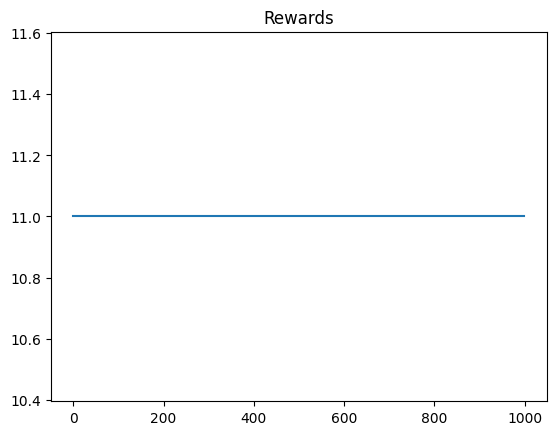

In [455]:
plt.plot(totalrewards)
plt.title("Rewards")
plt.show()


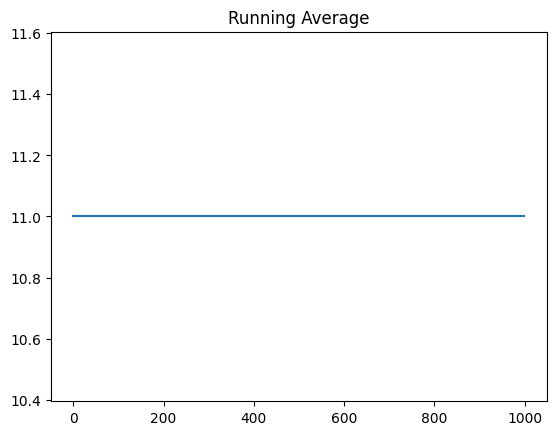

In [433]:
plot_running_avg(totalrewards)